# Location Mention Recognition - BERT fine-tuning

This project involves developing an automated process for recognition of toponyms (place/ area/ street names) in microblogging posts. The aim is to help authorities determine specific locations to send resources such as medical aid, food.

The microblogging data used will be Twitter (X) posts and a Location Mention Recognition system will be built.

0.Setup
1. Read Data
2. Clean Dataset
3. Text and Label Tokenization
4. Load BERT and Define Optimizer
5. Define Training and Evaluation Functions
6. Training (Fine-Tuning)
7. Evaluation
8. Conclusion

## 0. Setup


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# imports
import numpy as np
import pandas as pd
import requests
from google.colab import userdata
import torch
from transformers import BertTokenizer, BertTokenizerFast, AutoTokenizer, BertForTokenClassification, pipeline, BertModel
import warnings
import re
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
from tqdm import tqdm
from torch import nn
import evaluate
import matplotlib.pyplot as plt
from jiwer import wer

In [ ]:
if torch.cuda.is_available():
    print("GPU is available")
else:
    print("GPU is not available")

device = 'cuda' if torch.cuda.is_available() else 'cpu'

GPU is available


In [ ]:
# setup
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_colwidth', None)
warnings.filterwarnings('ignore')

## 1. Read Data

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/data_challenges/zindi_microsoft_LMR_challenge/data/Train.csv')
train_df.head(3)

,tweet_id,text,location
0,ID_1001136212718088192,NaN,EllicottCity
1,ID_1001136696589631488,"Flash floods struck a Maryland city on Sunday, washing out streets and tossing cars like bath toys.",Maryland
2,ID_1001136950345109504,State of emergency declared for Maryland flooding: via @YouTube,Maryland


In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/data_challenges/zindi_microsoft_LMR_challenge/data/Test.csv')
test_df.head(3)

,tweet_id,text
0,ID_1001154804658286592,"What is happening to the infrastructure in New England? It isnt global warming, its misappropriated funds being abused that shouldve been used maintaining their infrastructure that couldve protected them from floods! Like New Orleans. Their mayor went to ὄ7#Maryland #floods"
1,ID_1001155505459486720,"SOLDER MISSING IN FLOOD.. PRAY FOR EDDISON HERMOND! PRAY FOR ELLICOTT CITY, MARYLAND! #PrayForEddisonHermond #PrayForEllicottCity"
2,ID_1001155756371136512,"RT @TIME: Police searching for missing person after devastating 1,000-year flood in Ellicott City, Maryland"


## 2. Clean Dataset

In [ ]:
# drop NaN
train_df = train_df.dropna()

## 3. Text and Label Tokenization
- sources:
  - https://www.analyticsvidhya.com/blog/2022/11/comprehensive-guide-to-bert/
  - https://www.kaggle.com/code/thanish/bert-for-token-classification-ner-tutorial
- Tokenize train sentence
- Tokenize label
- For each tokenized label, loop the tokenized train sentence, whereever there is a match label as 'B' else 'O'
- Convert alphabetic labels to numerical labels
  O -> 0
  B -> 1
  P -> 2 (padding)

In [ ]:
# Load pre-trained BERT model and tokenizer
#tokenizer = AutoTokenizer.from_pretrained('bert-base-cased', use_fast=False)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# return a binary array of the same length of the tokenized text
# 1s correspond to the tokens which are present in the tokenized location
def get_binary_location_labels(tokenized_text, tokenized_location):

  binary_location_labels = [0]*len(tokenized_text)

  for location_i in range(len(tokenized_location)):
    for text_j in range(len(tokenized_text)):
      if tokenized_text[text_j]==0:
        binary_location_labels[text_j]=-100
      elif tokenized_text[text_j] == tokenized_location[location_i]:
        binary_location_labels[text_j]=1

  return binary_location_labels

In [ ]:
# tokenize text
# create binary label for text
def tokenize_and_label(text, location=None):

  tokenized_text_dict = tokenizer(text, truncation=True, padding='max_length', max_length=450)

  if location is not None:
    tokenized_location_dict = tokenizer(location, truncation=True, padding='max_length', max_length=450)
    tokenized_text_dict['labels']=get_binary_location_labels(tokenized_text_dict['input_ids'], tokenized_location_dict['input_ids'])

  tokenized_text_dict['input_ids'] = torch.tensor(tokenized_text_dict['input_ids']).squeeze(0)
  tokenized_text_dict['attention_mask'] = torch.tensor(tokenized_text_dict['attention_mask']).squeeze(0)
  tokenized_text_dict['token_type_ids'] = torch.tensor(tokenized_text_dict['token_type_ids']).squeeze(0)

  if location is not None:
    tokenized_text_dict['labels'] = torch.tensor(tokenized_text_dict['labels']).squeeze(0)

  return tokenized_text_dict

- We will use 450 as max length for BERT sentence, however, on test dataset, we will have to truncate sentences of length greater than this

In [ ]:
train_df.head(3)

,tweet_id,text,location
1,ID_1001136696589631488,"Flash floods struck a Maryland city on Sunday, washing out streets and tossing cars like bath toys.",Maryland
2,ID_1001136950345109504,State of emergency declared for Maryland flooding: via @YouTube,Maryland
3,ID_1001137334056833024,"Other parts of Maryland also saw significant damage from Sundays storms including this Baltimore city neighborhood, #Dundalk and #Catonsville. Rain totals spanned from 1 to 10 inches across Maryland: #ECFlood",Baltimore Maryland


In [ ]:
test_text = 'Flash floods struck a Maryland city on Sunday, washing out streets and tossing cars like bath toys.'
test_location = 'Maryland'

In [ ]:
#tokenize_and_label(test_text)

We will be splitting the Train dataset into 3 datasets:
1. X_train: used in fine-tuning (train phase)
2. X_val: used in fine-tuning (evaluation phase)
3. X_eval_test: used to evaluate the fine-tuned model


The Test dataset is an unlabelled one, the predictions on this dataset will be submitted for the data challenge.


In [ ]:
# split dataset into train and validation
X_train, X_val, y_train, y_val = train_test_split(
    train_df, train_df['location'], test_size=0.2, random_state=42)

# split dataset into train and validation
X_train, X_eval_test, y_train, y_eval_test = train_test_split(
    X_train, X_train['location'], test_size=0.25, random_state=42)

In [ ]:
print('X_train shape: ' + str(X_train.shape))
print('X_val shape: ' + str(X_val.shape))
print('X_eval_test shape: ' + str(X_eval_test.shape))

X_train shape: (7109, 3)
X_val shape: (2370, 3)
X_eval_test shape: (2370, 3)


In [ ]:
# tokenize train dataset
tokenized_train_dataset = X_train.apply(lambda x: tokenize_and_label(x['text'], x['location']), axis=1) #4 mins
tokenized_train_dataset.reset_index(drop=True, inplace=True)

In [ ]:
# tokenize validation dataset
tokenized_val_dataset = X_val.apply(lambda x: tokenize_and_label(x['text'], x['location']), axis=1) # 1 min
tokenized_val_dataset.reset_index(drop=True, inplace=True)

In [ ]:
# Convert datasets into DataLoader objects
train_dataloader = DataLoader(tokenized_train_dataset, sampler=RandomSampler(tokenized_train_dataset), batch_size=8)
val_dataloader = DataLoader(tokenized_val_dataset, sampler=SequentialSampler(tokenized_val_dataset), batch_size=16)

## 4. Load BERT and define Optimizer

In [ ]:
# Load pre-trained BERT model
model = BertForTokenClassification.from_pretrained('bert-base-uncased', num_labels=2)  # 2 labels for binary classification
model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [ ]:
# Optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Total number of training steps
total_steps = len(train_dataloader) * 3  # 3 epochs

# Scheduler to decrease learning rate linearly
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Loss function is included in the model

## 5. Training and Evaluation Functions

In [ ]:
# Training function
def train_model(model, train_dataloader, optimizer, scheduler, device):
    model.train()
    total_loss = 0

    # Loop through batches
    for batch in tqdm(train_dataloader, desc="Training"):

        # Move batch to device (GPU/CPU)
        batch = {k: v.to(device) for k, v in batch.items()}

        # Forward pass
        outputs = model(**batch)
        loss = outputs.loss

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        # Accumulate loss
        total_loss += loss.item()

    avg_loss = total_loss / len(train_dataloader)
    return avg_loss

In [ ]:
# Validation function
def evaluate_model(model, val_dataloader, device):
    model.eval()
    total_loss = 0
    correct_preds = 0
    total_preds = 0

    with torch.no_grad():
        for batch in tqdm(val_dataloader, desc="Validating"):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            logits = outputs.logits

            total_loss += loss.item()

            predictions = torch.argmax(logits, dim=-1)
            labels = batch['labels']

            # Calculate accuracy, ignoring padding (-100 labels)
            mask = labels != -100
            correct_preds += (predictions[mask] == labels[mask]).sum().item()
            total_preds += mask.sum().item()

    avg_loss = total_loss / len(val_dataloader)
    accuracy = correct_preds / total_preds
    return avg_loss, accuracy

## 6. Training (Fine-Tuning)

In [ ]:
# about 10 mins per epoch
epochs = 5
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")

    # Train
    train_loss = train_model(model, train_dataloader, optimizer, scheduler, device)
    train_losses.append(train_loss)
    print(f"Training loss: {train_loss}")

    # Validate
    val_loss, val_accuracy = evaluate_model(model, val_dataloader, device)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    print(f"Validation loss: {val_loss}, Validation accuracy: {val_accuracy}")

    # save mode at each epoch
    torch.save(model, '/content/drive/MyDrive/data_challenges/zindi_microsoft_LMR_challenge/models/model_lmr_portfolio_'+str(epoch))

Epoch 1/5


Training: 100%|██████████| 889/889 [09:44<00:00,  1.52it/s]


Training loss: 0.0442182495950431


Validating: 100%|██████████| 149/149 [01:06<00:00,  2.25it/s]


Validation loss: 0.039268930505136114, Validation accuracy: 0.9865097867793482
Epoch 2/5


Training: 100%|██████████| 889/889 [09:44<00:00,  1.52it/s]


Training loss: 0.028947338498018355


Validating: 100%|██████████| 149/149 [01:06<00:00,  2.26it/s]


Validation loss: 0.039905041464035645, Validation accuracy: 0.9865704988100442
Epoch 3/5


Training: 100%|██████████| 889/889 [09:43<00:00,  1.52it/s]


Training loss: 0.02088681505602775


Validating: 100%|██████████| 149/149 [01:06<00:00,  2.26it/s]


Validation loss: 0.04223534470774083, Validation accuracy: 0.9864005051240954
Epoch 4/5


Training: 100%|██████████| 889/889 [09:45<00:00,  1.52it/s]


Training loss: 0.019558478034566566


Validating: 100%|██████████| 149/149 [01:06<00:00,  2.25it/s]


Validation loss: 0.04223534470774083, Validation accuracy: 0.9864005051240954
Epoch 5/5


Training: 100%|██████████| 889/889 [09:43<00:00,  1.52it/s]


Training loss: 0.01918716348995244


Validating: 100%|██████████| 149/149 [01:05<00:00,  2.26it/s]


Validation loss: 0.04223534470774083, Validation accuracy: 0.9864005051240954


In [ ]:
# evaluate non fine-tuned model
initial_model = BertForTokenClassification.from_pretrained('bert-base-uncased', num_labels=2)  # 2 labels for binary classification
initial_model.to(device)
initial_val_loss, initial_val_accuracy = evaluate_model(initial_model, val_dataloader, device)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 149/149 [01:06<00:00,  2.24it/s]


In [ ]:
print('initial model validation loss: ' +str(initial_val_loss))
print('initial model accuracy loss: ' +str(initial_val_accuracy))

initial model validation loss: 0.5906223366724564
initial model accuracy loss: 0.7517727912963232


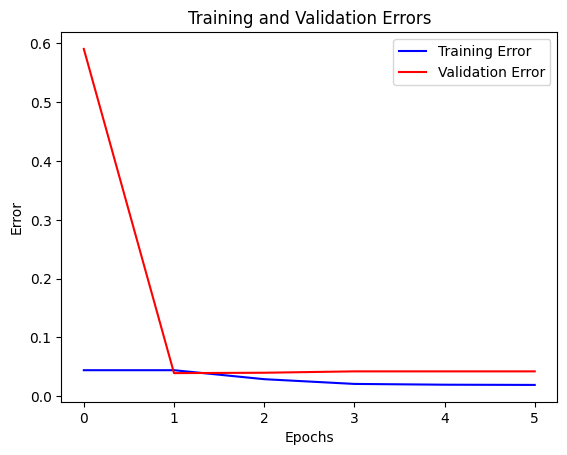

In [ ]:
# Plotting training and validation errors
epochs_range = np.array(range(epochs)) + 1
epochs_range = np.append([0], epochs_range)

train_losses = np.append([train_losses[0]], train_losses)
val_losses = np.append([initial_val_loss], val_losses)

# Plotting
plt.plot(epochs_range, train_losses, 'b-', label='Training Error')
plt.plot(epochs_range, val_losses, 'r-', label='Validation Error')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.title('Training and Validation Errors')
plt.legend()

# Display the plot
plt.show()

From the training and validation curves, we can see that the 1st epoch is enough.

In [ ]:
model=torch.load('/content/drive/MyDrive/data_challenges/zindi_microsoft_LMR_challenge/models/model_lmr_portfolio_0')

## 7. Evaluation

Evaluation metric: Word Error Rate Metric

In [ ]:
def predict_locations(model, dataloader):
  # Assume you have a pre-trained BERT model loaded (for binary classification)
  model.eval()  # Set the model to evaluation mode

  # Move the model to the device
  model = model.to(device)

  # Make predictions (forward pass)
  with torch.no_grad():  # Disable gradient calculations for inference

    predicted_locations = []

    for batch in tqdm(dataloader, desc="Predicting"):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            #loss = outputs.loss
            logits = outputs.logits
            probs = torch.softmax(logits, dim=-1)
            batch_predicted_classes = torch.argmax(probs, dim=-1)
            batch_predicted_classes = batch_predicted_classes.cpu().numpy()

            input_ids = batch['input_ids'].cpu().numpy()

            cls_token = tokenizer.decode(tokenizer.cls_token_id).replace(' ', '')
            pad_token = tokenizer.decode(tokenizer.pad_token_id).replace(' ', '')
            sep_token = tokenizer.decode(tokenizer.sep_token_id).replace(' ', '')

            tokens = [tokenizer.decode(id) for id in input_ids]

            batch_predicted_locations = [tokenizer.decode([input_ids[i][j] for j in range(len(batch_predicted_classes[i])) if batch_predicted_classes[i][j]==1]) for i in range(len(batch_predicted_classes))]
            batch_predicted_locations = [str.strip(string.replace(cls_token, '').replace(pad_token, '').replace(sep_token, '')) for string in batch_predicted_locations]

            predicted_locations.extend(batch_predicted_locations)

  return predicted_locations

In [ ]:
eval_test_df = pd.DataFrame({'text': X_eval_test['text'], 'location': X_eval_test['location']})
eval_test_df.reset_index(drop=True, inplace=True)
eval_test_df.head(3)

,text,location
0,Wife of @StephenCurry30 responds to Trump’s attacks by asking him to donate to Mexico earthquake victims. That’s how you use the limelight!,Mexico
1,"Kerala needs your help, we are sending medicines for people affected by flood. If you want to help, please send them to our office: You can send: OTC medicines, sanitary pads and dry food items. Let’s do our bit ὤFἿD #KeralaFloods #KeralaFloodRelief",Kerala
2,@TheEllenShow Ecuador needs the help of everyone. Please!,Ecuador


In [ ]:
# tokenize data
tokenized_eval_test_dataset = eval_test_df.apply(lambda x: tokenize_and_label(x['text']), axis=1) # 1 min

In [ ]:
# load dataset
eval_test_dataloader = DataLoader(tokenized_eval_test_dataset, batch_size=16)

In [ ]:
eval_test_predicted_locations = predict_locations(model, eval_test_dataloader)

Predicting: 100%|██████████| 149/149 [01:08<00:00,  2.18it/s]


In [ ]:
eval_test_df = pd.DataFrame({'text': X_eval_test['text'], 'location': X_eval_test['location'], 'predicted_location': eval_test_predicted_locations})

In [ ]:
print('percentage missing locations in labels:')
print(str((len(eval_test_df[eval_test_df['location']==''])/len(eval_test_df))*100))

print('percentage missing locations in predictions:')
print(str((len(eval_test_df[eval_test_df['predicted_location']==''])/len(eval_test_df))*100))

percentage missing locations in labels:
0.0
percentage missing locations in predictions:
0.16877637130801687


In [ ]:
wer = evaluate.load("wer")
word_error_rate = wer.compute(references=eval_test_df['location'].tolist(), predictions=eval_test_df['predicted_location'].tolist())
print('word error rate: ' + str(word_error_rate))

word error rate: 1.184952189229995


In [ ]:
eval_test_df.sample(20)

,text,location,predicted_location
37999,RT @redcrossny: #RedCross in Ecuador on the ground helping following yesterdays earthquake there. Follow @cruzrojaecuador for updates.,Ecuador,ecuador
47419,RT @Slate: Harvey death toll increases as rising floodwaters leave hundreds stranded in Texas.,Texas,texas
66523,"RT @the_chill_son: I am active duty military, w/ supplies, trying to get to St. Croix. Currently flying to St. Thomas on Sunday. Help! #stc",St. Croix,st. croix. st. thomas.
65987,Rescuers are racing against the clock to reach survivors trapped under the rubble of a school in Mexico which collapsed during Earthquake.,Mexico,mexico
42596,"DEVELOPING: Hurricane Matthew lashes Haiti & Cuba, amid States of Emergency along US east coast. @Miguelnbc reports now on @NBCNightlyNews.",Haiti Cuba,haiti cuba us
40546,App released for Fort McMurray evacueesuses satellite images provided by government of Canada from Pléaides-1A,Fort McMurray Canada,fort mcmurray canada
31248,"As #HurricaneDorian barrels toward Florida, the American Humane Rescue team is standing by, ready to deploy our team & resources to help animals in the storms path. Visit our blog for tips to keep your family safe before, during, & after the storm:",Florida,florida
30,"Army National Guardsman missing after massive flooding hits Ellicott City, Maryland. Thoughts and prayers with Eddison Alexander Hermond and his family. I sure hope they find him alive and well.",Ellicott City Maryland,ellicott city maryland
24279,"DEATH TOLL from tropical cyclone Idai, which smashed into Mozambique and Zimbabwe, rises to more than 300 as rescuers race to help survivors.",Zimbabwe Mozambique,mozambique zimbabwe
66446,RT @TIME: Death toll climbs to 305 as another earthquake hits Mexico City,Mexico,mexico city


## 8. Conclusion


Using BERT pretrained Named Entity Recognition model gave the following results:
- Percentage missing location: 16.15%
- Word Error Rate: 0.566%

Fine-tuning BERT pretrained model on the given dataset gave the following results:
- Percentage missing location: 0.169%
- Word Error Rate: 1.185%

Further improvement may include working on merging sub-word tokens.

A quick scan of the results shows that the given labels may sometimes contain errors or be incomplete such as the following examples where the model may be more accurate.

| text              |  label | predicted location |
| :---------------: | :------: | :----:|
| RT @the_chill_son: I am active duty military, w/ supplies, trying to get to St. Croix. Currently flying to St. Thomas on Sunday. Help! #stc        |   St. Croix   | st. croix. st. thomas. |
| DEVELOPING: Hurricane Matthew lashes Haiti & Cuba, amid States of Emergency along US east coast. @Miguelnbc reports now on @NBCNightlyNews.           |   Haiti Cuba   | haiti cuba us |
| Whoa. Craven County (includes New Bern, isnt a county with beachfront areas) has ordered a mandatory evacuation #HurricaneFlorence    |  Whoa. Craven New Bern   | craven county new bern |

